## Principal components analysis, feature selection \& clustering
### $\textit{Unsupervised classification of wine}$

This is an unsupervised analysis exercise on the "Wine" dataset from SKlearn [1,2]. The data is the results of a chemical analysis of 178 wines grown in the same region in Italy by three different cultivators. There are 13 different measurements taken for different constituents found in the wine, listed below.

### Features:
The data features / input variables (X) are:
* alcohol
* malic_acid
* ash
* alcalinity_of_ash
* magnesium
* total_phenols
* flavanoids
* nonflavanoid_phenols
* proanthocyanins
* color_intensity
* hue
* od280/od315_of_diluted_wines
* proline

Note, that there is a target value (target = cultivator [0, 1, 2]) in the data, but that this is only for checking how well your dimensionality reduction / clustering works.

### Structure of this notebook:
1. Data exploration, visualization \& preprocessing
2. PCA analysis, feature selection \& dimensionality reduction
3. Combining PCA analysis with K-means \& DBSCAN


***

$\textit{Authors:}$ Nikolaj Krebs \& Simon Guldager \
$\textit{Date:}$ 11-09-2024

In [63]:
import numpy as np
import pandas as pd
import seaborn as sns


from sklearn import datasets
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from factor_analyzer.factor_analyzer import calculate_kmo

import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

## some stuff for making pretty plots
from matplotlib import rcParams
from cycler import cycler
## Set plotting style and print options
sns.set_theme()
sns.set_style("whitegrid")
sns.set_context("paper") #Possible are paper, notebook, talk and poster
# Set figure format
wide_format, square_format = False, True
if wide_format:
    d = {'lines.linewidth': 2, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12,\
     'legend.fontsize': 15, 'font.family': 'serif', 'figure.figsize': (9,6)}
if square_format:
    d = {'lines.linewidth': 2, 'axes.titlesize': 16, 'axes.labelsize': 14, 'xtick.labelsize': 10, 'ytick.labelsize': 10,\
     'legend.fontsize': 12, 'font.family': 'serif', 'figure.figsize': (6,6)}
    
d_colors = {'axes.prop_cycle': cycler(color = ['teal', 'navy', 'coral', 'plum', 'purple', 'olivedrab',\
         'black', 'red', 'cyan', 'yellow', 'khaki','lightblue'])}
rcParams.update(d)
rcParams.update(d_colors)

****

#### Data exploration \& visualization

In [64]:
#Let's import the data from sklearn
from sklearn.datasets import load_wine
wine=load_wine()

#Conver to pandas dataframe
data=pd.DataFrame(data=np.c_[wine['data'],wine['target']],columns=wine['feature_names']+['target'])

#Check data with info function
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  targe

In [65]:
# Search for missing, NA and null values)
(data.isnull() | data.empty | data.isna()).sum()

alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
target                          0
dtype: int64

In [66]:
#Let's see the frequency of the variable target.
#Convert variable to categorical.
data.target=data.target.astype('int64').astype('category')

#Frequency.
freq=data['target'].value_counts()

freq

target
1    71
0    59
2    48
Name: count, dtype: int64

<Axes: xlabel='target'>

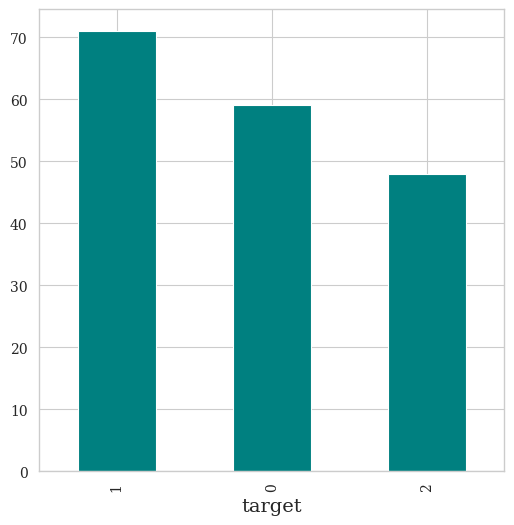

In [67]:
#Let's check graphically.
freq.plot(kind='bar')

In [68]:
#Let's show a summary of teh dataset where we can see 
# the basic statistic data.
data.describe()

alcohol  malic_acid         ash  alcalinity_of_ash   magnesium  \
count  178.000000  178.000000  178.000000         178.000000  178.000000   
mean    13.000618    2.336348    2.366517          19.494944   99.741573   
std      0.811827    1.117146    0.274344           3.339564   14.282484   
min     11.030000    0.740000    1.360000          10.600000   70.000000   
25%     12.362500    1.602500    2.210000          17.200000   88.000000   
50%     13.050000    1.865000    2.360000          19.500000   98.000000   
75%     13.677500    3.082500    2.557500          21.500000  107.000000   
max     14.830000    5.800000    3.230000          30.000000  162.000000   

       total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
count     178.000000  178.000000            178.000000       178.000000   
mean        2.295112    2.029270              0.361854         1.590899   
std         0.625851    0.998859              0.124453         0.572359   
min         0.980000    0.340000              0.130000         0.410000   
25%         1.742500    1.205000              0.270000         1.250000   
50%         2.355000    2.135000              0.340000         1.555000   
75%         2.800000    2.875000              0.437500         1.950000   
max         3.880000    5.080000              0.660000         3.580000   

       color_intensity         hue  od280/od315_of_diluted_wines      proline  
count       178.000000  178.000000                    178.000000   178.000000  
mean          5.058090    0.957449                      2.611685   746.893258  
std           2.318286    0.228572                      0.709990   314.907474  
min           1.280000    0.480000                      1.270000   278.000000  
25%           3.220000    0.782500                      1.937500   500.500000  
50%           4.690000    0.965000                      2.780000   673.500000  
75%           6.200000    1.120000                      3.170000   985.000000  
max          13.000000    1.710000                      4.000000  1680.000000

Correlation matrix

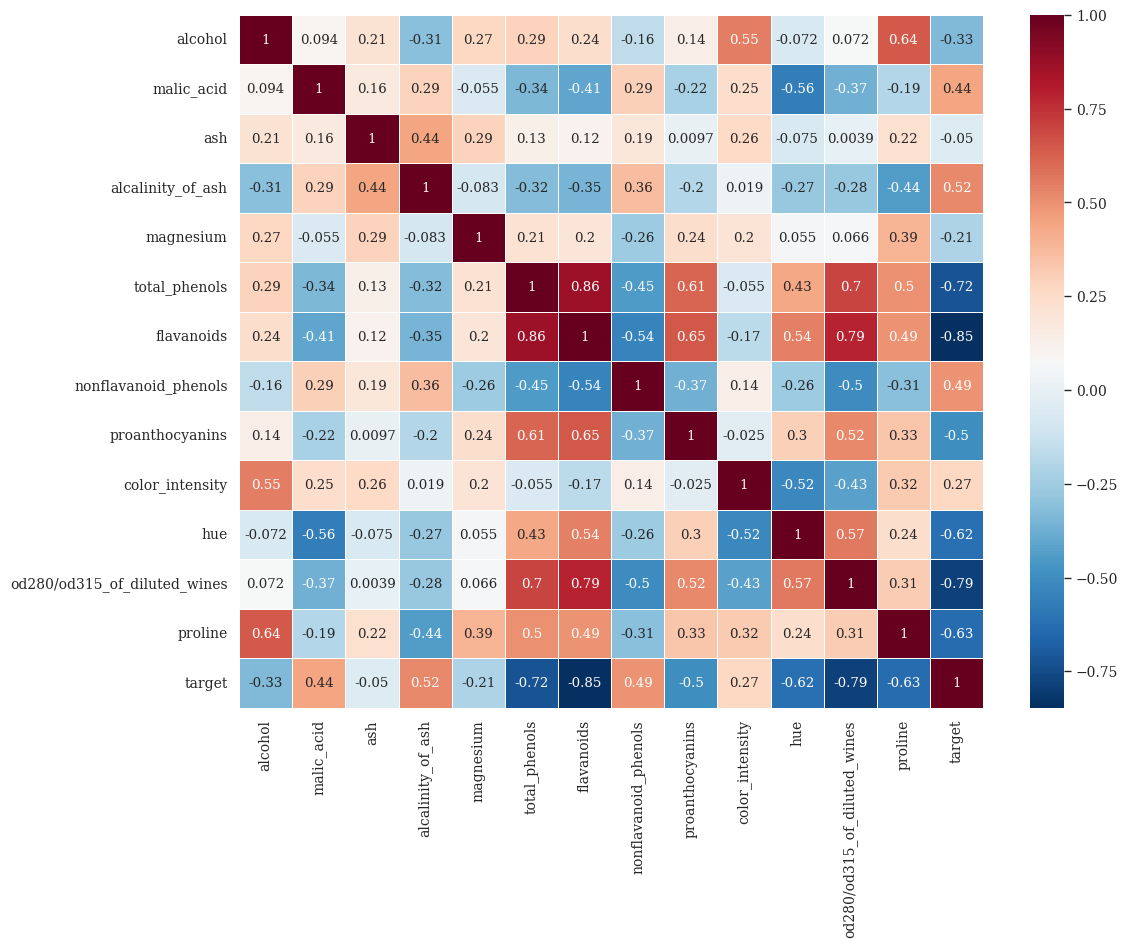

In [69]:
# Compute the pairwise Pearson correlation matrix for df.
# The Pearson correlation coefficient measures the linear relationship between two variables.
# Its value ranges from -1 to 1, where:
# - 1 implies a perfect positive linear relationship,
# - -1 implies a perfect negative linear relationship, and
# - 0 implies no linear relationship.
corr = data.corr(method='pearson')

# Create a new figure and axis with a specified size.
# Adjust the figsize values to change the size of each cell in the heatmap.
fig, ax = plt.subplots(figsize=(12, 9))

# Create a heatmap using Seaborn.
# - `corr`: The computed correlation matrix.
# - `xticklabels` & `yticklabels`: Use the columns of the correlation matrix for labeling the x and y axis respectively.
#   blue represents positive correlations and red represents negative correlations.
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu_r', annot=True, linewidth=0.5, ax=ax);


c:\Users\Simon Andersen\miniconda3\envs\BigData\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


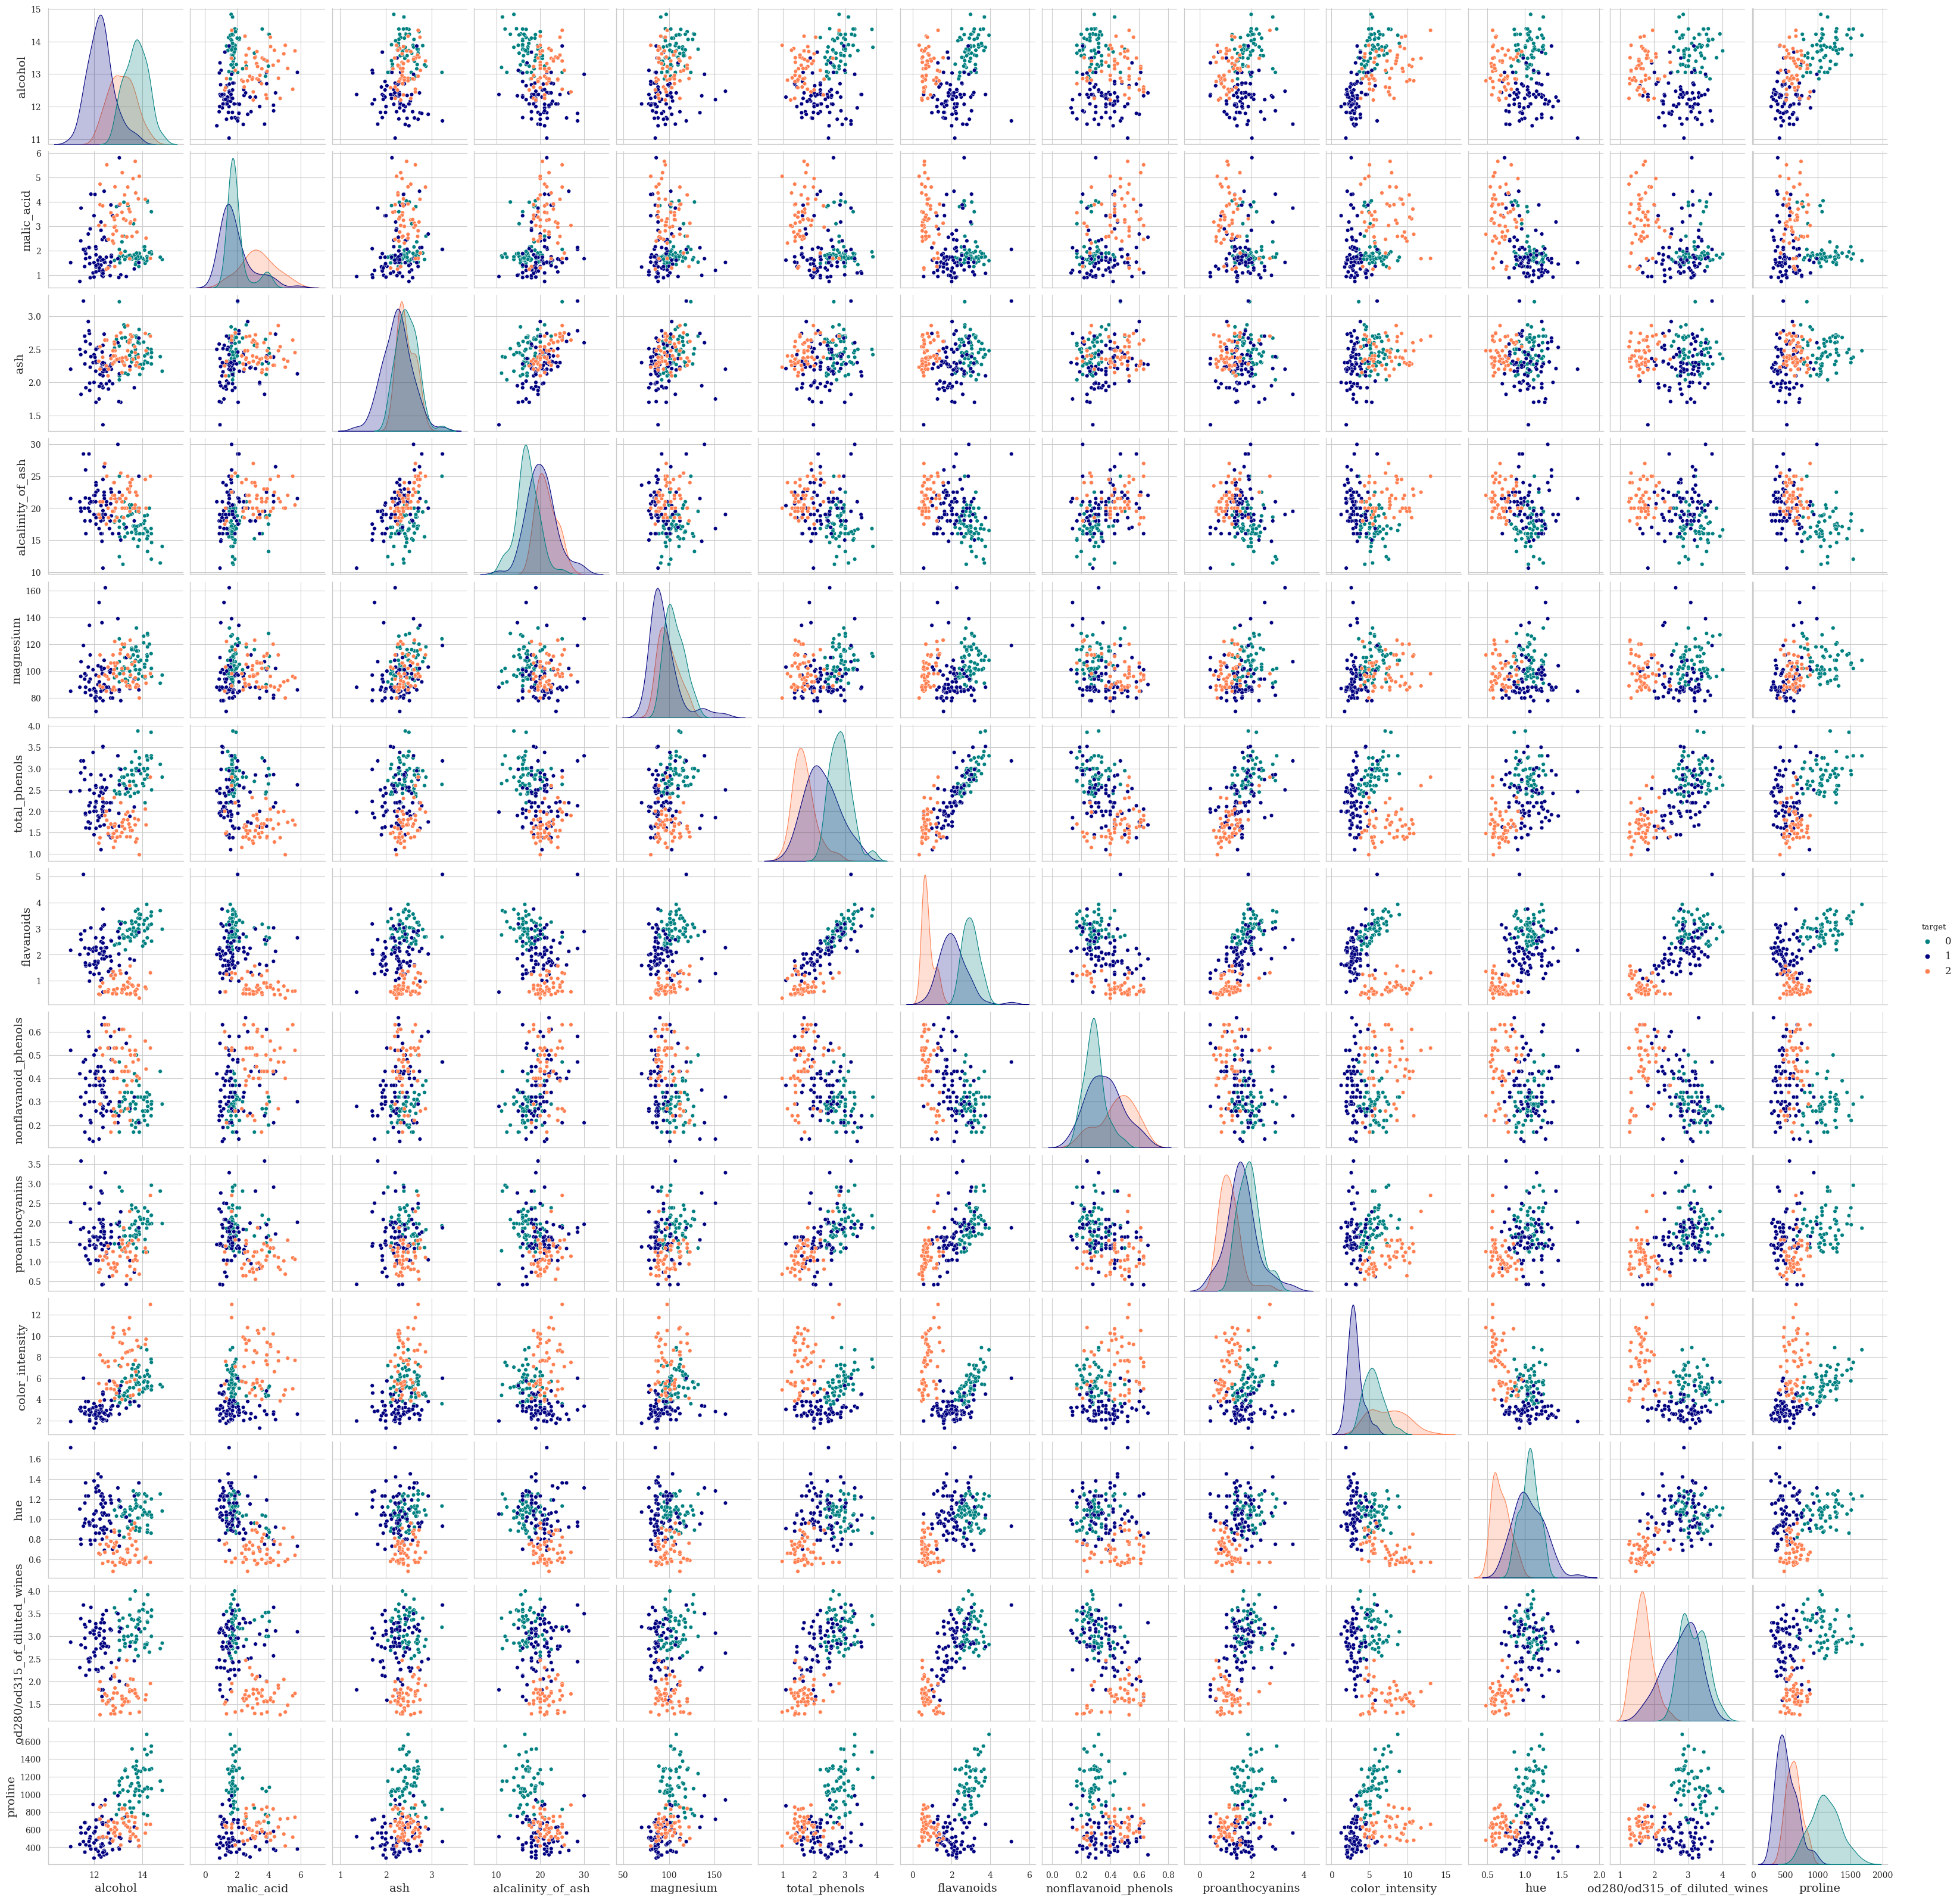

In [7]:
#scatter plots (it takes a couple of minutes to run)
sns.pairplot(data,hue='target')

****

#### Data preprocessing

Feature scaling

In [70]:
# Initialize the StandardScaler object
# StandardScaler standardizes the dataset by setting the mean to 0 and variance to 1
scaler = StandardScaler()

data_X = data.drop(['target'], axis=1) #We are not going to use the target for unsupervised learning

# Fit and transform the data
X = scaler.fit_transform(data_X)


Is data suitable for PCA analysis?

The Kaiser-Meyer-Olkin (KMO) Test is a measure of how suited your data is for Factor Analysis. The test measures sampling adequacy for each variable in the model and for the complete model. The statistic is a measure of the proportion of variance among variables that might be common variance. The lower the proportion, the more suited your data is to Factor Analysis.

KMO returns values between 0 and 1. A rule of thumb for interpreting the statistic:

KMO values between 0.8 and 1 indicate the sampling is adequate.
KMO values less than 0.6 indicate the sampling is not adequate and that remedial action should be taken. Some authors put this value at 0.5, so use your own judgment for values between 0.5 and 0.6.
KMO Values close to zero means that there are large partial correlations compared to the sum of correlations. In other words, there are widespread correlations which are a large problem for factor analysis.

reference: https://www.statisticshowto.com/kaiser-meyer-olkin/

In [71]:
# Kaiser-Meyer-Olkin (KMO) Test measures the suitability of data for factor analysis. 
# It determines the adequacy for each observed variable and for the complete model. 
# KMO estimates the proportion of variance among all the observed variable. 
# Lower proportion id more suitable for factor analysis. KMO values range between 0 and 1. 
# NB! Value of KMO less than 0.6 is considered inadequate.
kmo_all,kmo_model=calculate_kmo(X)
kmo_model

0.7786821205606519

#### PCA analysis \& feature selection

In [72]:
# Perform Principal Component Analysis (PCA) on the standardized DataFrame
# Initialize the PCA object and specify the number of components to keep (n_components)
nfeatures = X.shape[-1]
pca = PCA(n_components=nfeatures)

# Fit the PCA model to the scaled data
# This computes the principal components of the data
X_new_full = pca.fit_transform(X)

# Transform the scaled data into the new lower-dimensional representation
# The result is stored in a new DataFrame, where each column represents a principal component (PC)
# construct list of column names
columns = ['PC_'+str(i) for i in range(1, nfeatures+1)]
df_X_full= pd.DataFrame(X_new_full, columns=columns)

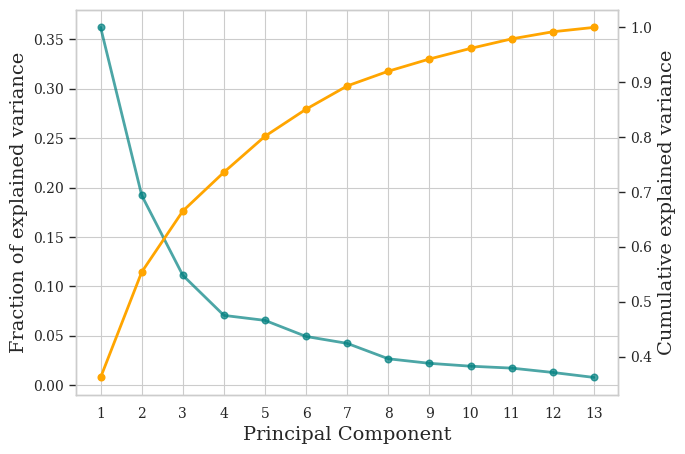

In [73]:
# Create a scree plot to visualize the explained variance by each principal component
# The plot helps to decide how many principal components to keep

# Plot the explained variance values for each of the 10 principal components as a line plot
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(range(1, nfeatures+1), pca.explained_variance_ratio_, marker='o', alpha=.7)
ax.set(xlabel='Principal Component', ylabel='Fraction of explained variance', \
       xticks = range(1, nfeatures+1), xticklabels=range(1, nfeatures+1))

# plot cumulative explained variance
axx = ax.twinx()
axx.plot(range(1, nfeatures+1), np.cumsum(pca.explained_variance_ratio_), marker='o', color='orange')
axx.set(ylabel='Cumulative explained variance')
axx.grid();

Feature selection \& dimensionality reduction

In [76]:
# we choose 2 to allow for visualization of the data in 2D
ncomponents = 2
pca = PCA(n_components=ncomponents)
X_new_res = pca.fit_transform(X)

columns = ['PC_'+str(i) for i in range(1, ncomponents+1)]
df_X_res= pd.DataFrame(X_new_res, columns=columns)
df_y = pd.DataFrame(data = freq, columns = ['target'])

finalDf_res = pd.concat([df_X_res, data['target']], axis = 1)
finalDf_res.head()

PC_1      PC_2 target
0  3.316751 -1.443463      0
1  2.209465  0.333393      0
2  2.516740 -1.031151      0
3  3.757066 -2.756372      0
4  1.008908 -0.869831      0

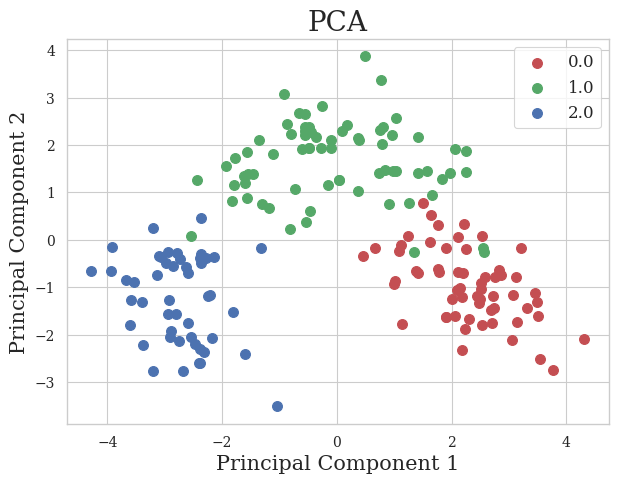

In [77]:
# Show the graphics.
fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA', fontsize = 20)
targets = [0.0, 1.0, 2.0]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf_res['target'] == target
    ax.scatter(finalDf_res.loc[indicesToKeep, 'PC_1']
               , finalDf_res.loc[indicesToKeep, 'PC_2']
               , c = color
               , s = 50)
ax.legend(targets);

### Clustering

To avoid the curse of dimensionality (and/or to make 2D visualization possible), PCA can be performed to reduce the number of features, after which we can do clustering

$\textbf{NB}$: One can also do cluster analysis using all features, and then use PCA analysis afterwards to reduce the number of features to e.g. 2, allowing for visualization of the clustering results.


.....

#### PCA + K-Means clustering

.. since we know that there are 3 clusters in this case, we don't have to worry about finding the optimal number of clusters

In [78]:
# k-means with 3 clusters
kmeans = KMeans(n_clusters=3, init='k-means++', 
                n_init=5, random_state=42)
y_pred = kmeans.fit_predict(X_new_res)

# make a dataframe with the results
df_X_kmeans = pd.DataFrame(data = X_new_res
             , columns = ['PC 1', 'PC 2'])
df_y_kmeans = pd.DataFrame(data = y_pred, columns = ['target'])

finalDf_kmeans = pd.concat([df_X_kmeans, df_y_kmeans], axis = 1)
finalDf_kmeans.head()


c:\Users\Simon Andersen\miniconda3\envs\BigData\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


PC 1      PC 2  target
0  3.316751 -1.443463       0
1  2.209465  0.333393       0
2  2.516740 -1.031151       0
3  3.757066 -2.756372       0
4  1.008908 -0.869831       0

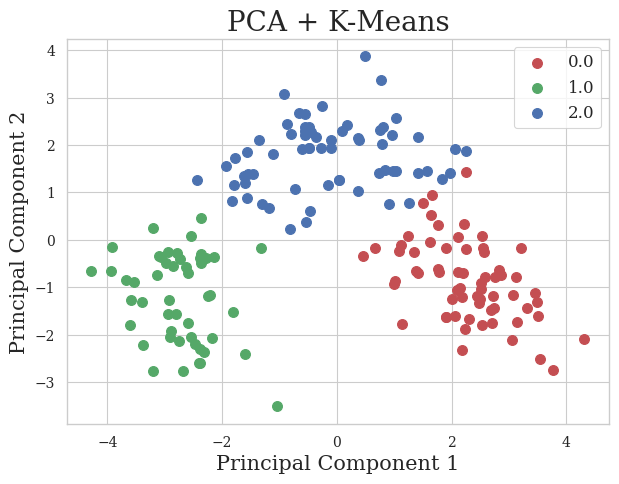

In [79]:
# Show the graphics.
fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA + K-Means', fontsize = 20)
targets = [0.0, 1.0, 2.0]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf_kmeans['target'] == target
    ax.scatter(finalDf_kmeans.loc[indicesToKeep, 'PC 1']
               , finalDf_kmeans.loc[indicesToKeep, 'PC 2']
               , c = color
               , s = 50)
ax.legend(targets)

#### PCA + DBSCAN 



The model output an integer value: '-1' for outliers and the rest for clusters.

Since we need 3 clusters, eps is chosen to give exactly that.

Estimated number of clusters: 3
Estimated number of noise points: 15


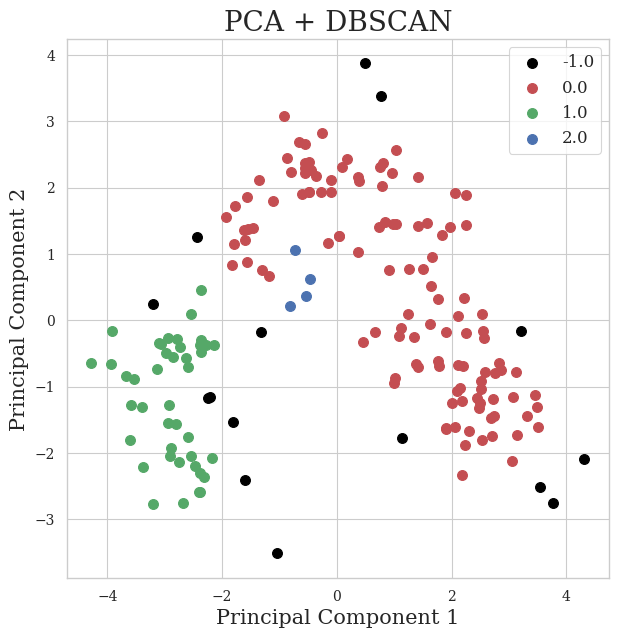

In [82]:
db = DBSCAN(eps=0.56, min_samples=2*ncomponents, leaf_size=1).fit(X_new_res)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

# make a dataframe with the results
df_X_dbscan = pd.DataFrame(data = X_new_res
             , columns = ['PC 1', 'PC 2'])
df_y_dbscan = pd.DataFrame(data = labels, columns = ['target'])

finalDf_dbscan = pd.concat([df_X_dbscan, df_y_dbscan], axis = 1);

# Show the graphics.
fig = plt.figure(figsize = (7, 7))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA + DBSCAN', fontsize = 20)
targets = [-1.0, 0.0, 1.0, 2.0]
colors = ['#000000','r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf_dbscan['target'] == target
    ax.scatter(finalDf_dbscan.loc[indicesToKeep, 'PC 1']
               , finalDf_dbscan.loc[indicesToKeep, 'PC 2']
               , c = color
               , s = 50)
ax.legend(targets)

We see that in this case (where the clusters are quite different in terms of the average distance between points in a cluster), DBSCAN does not do well.

***

## Exercise

Redo the analysis outlined in this notebook for the health_data_cleaned dataframe that we worked on in the previous exercises. 

$\textbf{Tip:}$ Make a copy of this notebook, and then go through it step by step using the health data  

$\textbf{NB:}$ Since we don't know the actual number of clusters, you will have to choose that (using any of the methods outlined in the clustering notebook). The target array used in this notebook is then given by the labels that you get by clustering.

$\textit{Considerations / ideas}$:
- Using 3 instead of 2 principal components, and visualizing the results in 3D
- Performing clustering on all features, and only then using PCA analysis to reduce the number of features, making possible visualization of the clustering
- Trying out other scalers (e.g. QuantileTransform instead of StandardScaler) or other clustering models